### Resources: https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly_express as px
import plotly.io as pio
import plotly.offline as pyo
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
pyo.init_notebook_mode(connected=True)

In [2]:
api_token = "<insert_your_mapbox_token_here>"

In [3]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)    
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
        
    return G

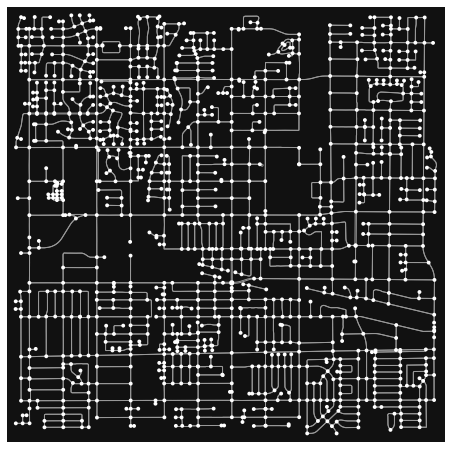

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
G = create_graph("Northridge, California, USA", 2500, "drive")
ox.plot_graph(G)

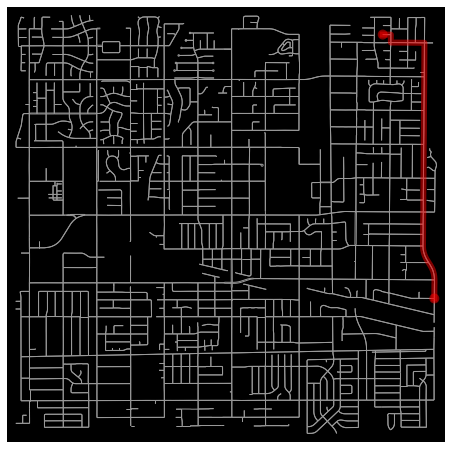

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
G = ox.add_edge_speeds(G) #Impute
G = ox.add_edge_travel_times(G) #Travel time

# start = (57.715495, 12.004210)
# end = (57.707166, 11.978388)

start = (34.2546975,-118.5165975)
end = (34.2272802, -118.5013579)

start_node = ox.get_nearest_node(G, start)
end_node = ox.get_nearest_node(G, end)# Calculate the shortest path
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')

#Plot the route and street networks
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [6]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [7]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from, X_to, Y_to, length, travel_time)),
                  columns =["node_start", "node_end", "X_from", "Y_from", "X_to", "Y_to", "length", 
                            "travel_time"])
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,123339752,123339749,-118.516531,34.254840,-118.515478,34.254832,97,9
1,123339749,122849534,-118.515478,34.254832,-118.515480,34.253985,94,7
2,122849534,122849531,-118.515480,34.253985,-118.513297,34.253976,201,16
3,122849531,122849529,-118.513297,34.253976,-118.512302,34.253966,91,7
4,122849529,294188611,-118.512302,34.253966,-118.511126,34.253956,108,8


In [8]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    
    return line_gdf

In [9]:
line_gdf = create_line_gdf(df)
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [10]:
df

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
0,123339752,123339749,-118.516531,34.254840,-118.515478,34.254832,97,9,POINT (-118.51653 34.25484),POINT (-118.5154775 34.2548321),"LINESTRING (-118.5154775 34.2548321, -118.5165..."
1,123339749,122849534,-118.515478,34.254832,-118.515480,34.253985,94,7,POINT (-118.51548 34.25483),POINT (-118.5154805 34.2539846),"LINESTRING (-118.5154805 34.2539846, -118.5154..."
2,122849534,122849531,-118.515480,34.253985,-118.513297,34.253976,201,16,POINT (-118.51548 34.25398),POINT (-118.5132971 34.2539756),"LINESTRING (-118.5132971 34.2539756, -118.5154..."
3,122849531,122849529,-118.513297,34.253976,-118.512302,34.253966,91,7,POINT (-118.51330 34.25398),POINT (-118.512302 34.2539656),"LINESTRING (-118.512302 34.2539656, -118.51329..."
4,122849529,294188611,-118.512302,34.253966,-118.511126,34.253956,108,8,POINT (-118.51230 34.25397),POINT (-118.5111259 34.2539562),"LINESTRING (-118.5111259 34.2539562, -118.5123..."
5,294188611,294188610,-118.511126,34.253956,-118.511148,34.250797,351,22,POINT (-118.51113 34.25396),POINT (-118.5111476 34.2507969),"LINESTRING (-118.5111476 34.2507969, -118.5111..."
6,294188610,123117770,-118.511148,34.250797,-118.511153,34.250318,53,3,POINT (-118.51115 34.25080),POINT (-118.511153 34.2503185),"LINESTRING (-118.511153 34.2503185, -118.51114..."
7,123117770,122650344,-118.511153,34.250318,-118.511190,34.246701,402,25,POINT (-118.51115 34.25032),POINT (-118.5111895 34.2467006),"LINESTRING (-118.5111895 34.2467006, -118.5111..."
8,122650344,652296402,-118.511190,34.246701,-118.511221,34.243076,403,25,POINT (-118.51119 34.24670),POINT (-118.5112213 34.2430761),"LINESTRING (-118.5112213 34.2430761, -118.5111..."
9,652296402,367952532,-118.511221,34.243076,-118.511253,34.239453,403,25,POINT (-118.51122 34.24308),POINT (-118.5112534 34.2394533),"LINESTRING (-118.5112534 34.2394533, -118.5112..."


In [11]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)
fig.update_layout(font_size=16,  title={'xanchor': 'center','yanchor': 'top', 'y':0.9, 'x':0.5,}, 
        title_font_size = 24, mapbox_accesstoken=api_token, 
                  mapbox_style = "mapbox://styles/strym/ckhd00st61aum19noz9h8y8kw")
fig.update_traces(marker=dict(size=6))

In [12]:
df

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
0,123339752,123339749,-118.516531,34.254840,-118.515478,34.254832,97,9,POINT (-118.51653 34.25484),POINT (-118.5154775 34.2548321),"LINESTRING (-118.5154775 34.2548321, -118.5165..."
1,123339749,122849534,-118.515478,34.254832,-118.515480,34.253985,94,7,POINT (-118.51548 34.25483),POINT (-118.5154805 34.2539846),"LINESTRING (-118.5154805 34.2539846, -118.5154..."
2,122849534,122849531,-118.515480,34.253985,-118.513297,34.253976,201,16,POINT (-118.51548 34.25398),POINT (-118.5132971 34.2539756),"LINESTRING (-118.5132971 34.2539756, -118.5154..."
3,122849531,122849529,-118.513297,34.253976,-118.512302,34.253966,91,7,POINT (-118.51330 34.25398),POINT (-118.512302 34.2539656),"LINESTRING (-118.512302 34.2539656, -118.51329..."
4,122849529,294188611,-118.512302,34.253966,-118.511126,34.253956,108,8,POINT (-118.51230 34.25397),POINT (-118.5111259 34.2539562),"LINESTRING (-118.5111259 34.2539562, -118.5123..."
5,294188611,294188610,-118.511126,34.253956,-118.511148,34.250797,351,22,POINT (-118.51113 34.25396),POINT (-118.5111476 34.2507969),"LINESTRING (-118.5111476 34.2507969, -118.5111..."
6,294188610,123117770,-118.511148,34.250797,-118.511153,34.250318,53,3,POINT (-118.51115 34.25080),POINT (-118.511153 34.2503185),"LINESTRING (-118.511153 34.2503185, -118.51114..."
7,123117770,122650344,-118.511153,34.250318,-118.511190,34.246701,402,25,POINT (-118.51115 34.25032),POINT (-118.5111895 34.2467006),"LINESTRING (-118.5111895 34.2467006, -118.5111..."
8,122650344,652296402,-118.511190,34.246701,-118.511221,34.243076,403,25,POINT (-118.51119 34.24670),POINT (-118.5112213 34.2430761),"LINESTRING (-118.5112213 34.2430761, -118.5111..."
9,652296402,367952532,-118.511221,34.243076,-118.511253,34.239453,403,25,POINT (-118.51122 34.24308),POINT (-118.5112534 34.2394533),"LINESTRING (-118.5112534 34.2394533, -118.5112..."


In [13]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", 
                        zoom=8, width=1000, height=800, animation_frame=df.index, mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])

fig.update_layout(font_size=16,  title={'xanchor': 'center','yanchor': 'top', 'y':0.9, 'x':0.5,}, 
        title_font_size = 24, mapbox_accesstoken=api_token)
fig